11:56:40 - cmdstanpy - INFO - Chain [1] start processing
11:56:41 - cmdstanpy - INFO - Chain [1] done processing


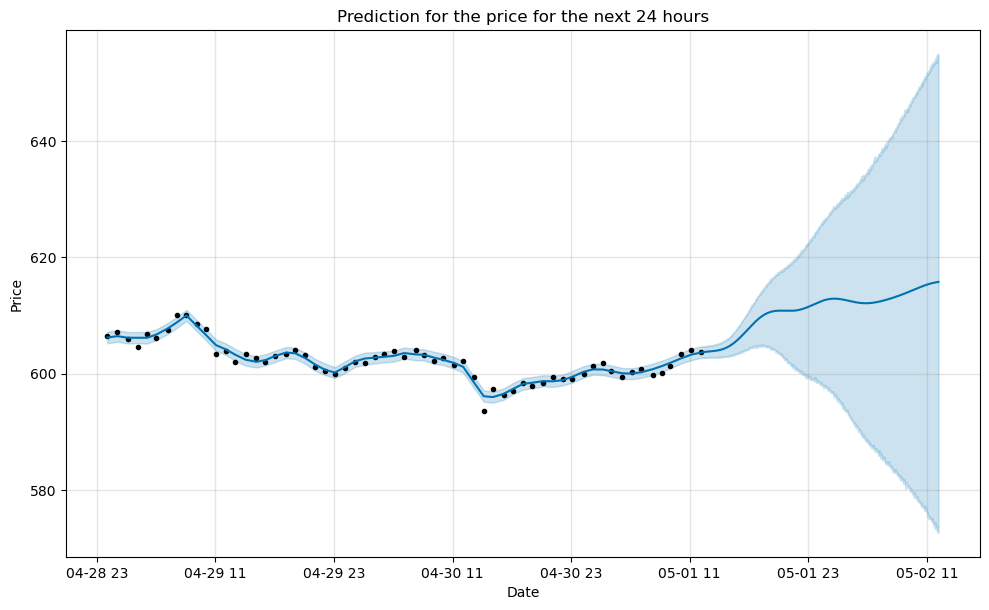

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


In [2]:
from utils import get_data_crypto, models


data = get_data_crypto().download_data_cloud(start_time='2025-04-29', end_time='2025-05-01 13:00:00', crypto="binancecoin", time='min')
prophet_model = models.prophet_model(data=data, time='min')


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from utils import get_data_crypto

from dotenv import load_dotenv

from binance.client import Client

from prophet import Prophet
import xgboost  as xgb

import  requests


import os  

def prophet_model(data, time):
    if len(data.columns) > 2:
        raise ValueError('Your dataset has more than two columns {data.columns}')
    
    data.columns = ['ds','y']

    model = Prophet(daily_seasonality=True)
    model.fit(data)

    if time == 'min':
        future = model.make_future_dataframe(periods=24*60, freq = time)
    elif time == 'S':
        future = model.make_future_dataframe(periods=24*60*60, freq = time)
    else:
        raise ValueError('Please write a correct option for time ("S" or "min")')
    
    df = model.predict(future)

    fig1 = model.plot(df)
    plt.title('Prediction for the price for the next 24 hours')
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.show()

    df = df[['ds', 'yhat']]
    df =df.rename({'yhat':'y'})

    predict = df[df['ds'] >= data['ds'].max()]
    
    return data, predict



In [ ]:
df_prophet= pd.read_excel('./df_prophet.xlsx')
predict_prophet = pd.read_excel('./predict_prophet.xlsx')


11:57:02 - cmdstanpy - INFO - Chain [1] start processing
11:57:02 - cmdstanpy - INFO - Chain [1] done processing


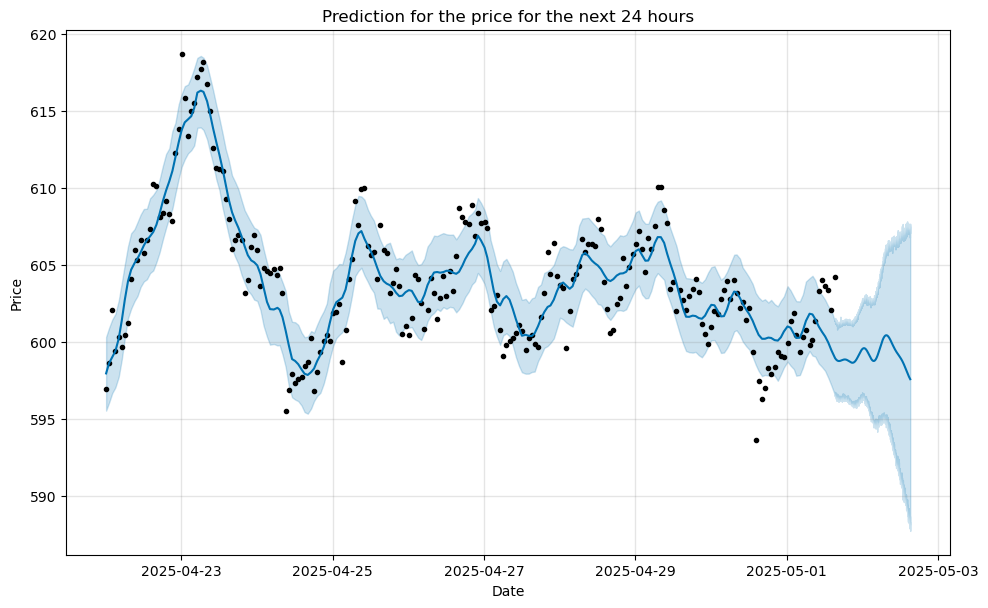

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


In [4]:
from utils import get_data_crypto, models

data = get_data_crypto().download_data_cloud(start_time='2025-04-22', end_time='2025-05-01 15:16:00', crypto="binancecoin", time='min')

df_prophet, predict_prophet = models.prophet_model(data=data, time='min')

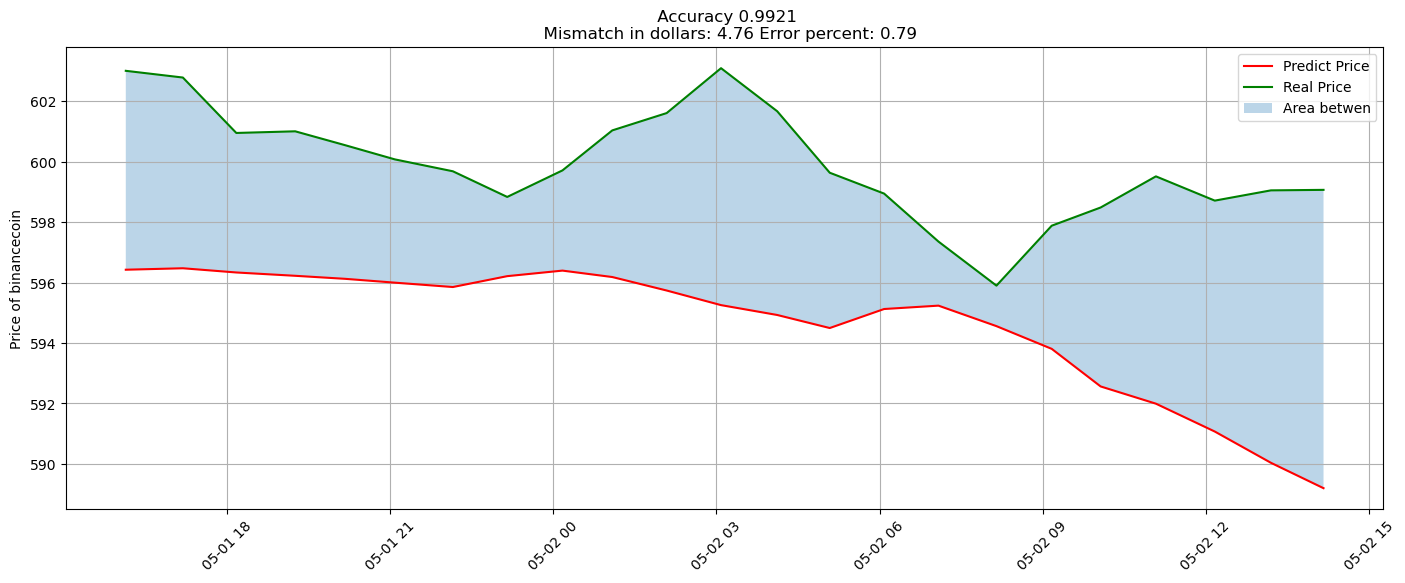

In [8]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 


import matplotlib.dates as mdates
from utils import get_data_crypto

def data_predict(model_pred, time, crypto ):
    model = model_pred.copy()

    model = model[['ds', 'yhat_lower']]
    model = model.rename(columns={'yhat_lower': 'predict price'})

    model = model[model['ds']>=model['ds'].max() - pd.Timedelta(minutes=24*60)]

    data = get_data_crypto().download_data_cloud(start_time=model['ds'].max() - pd.Timedelta(minutes=24*60) , end_time=model['ds'].max(), crypto=crypto, time=time)

    data.columns = ['ds','real price']

    if time == 'min':
        model['ds'] = model['ds'].dt.round(time)
        data['ds'] = data['ds'].dt.round(time)
        
    elif time == 'S':
        model['ds'] = model['ds'].dt.round(time)
        data['ds'] = data['ds'].dt.round(time)
    else:
        raise ValueError(f'Please write a correct option for the time {time}')


    df = pd.merge(left=model, right=data, on='ds', how='left')
    df = df.dropna(axis=0).reset_index(drop=True)

    df['difference'] = np.absolute(df['predict price'] - df['real price'])
    df['mismatch'] = df['difference']/df['real price']

    difference_shadow = round(np.trapz(df['difference'], x=mdates.date2num(df['ds'])), 2)
    mismatch_percent = round(np.trapz(df['mismatch'], x=mdates.date2num(df['ds'])), 4)

    plt.figure(figsize=(17,6))
    plt.plot(df['ds'], df['predict price'], c='r', label = 'Predict Price' )
    plt.plot(df['ds'], df['real price'], c='g', label='Real Price')
    plt.fill_between(df['ds'], df['real price'], df['predict price'], alpha=0.3, label='Area betwen')

    plt.title(f' Accuracy {1-mismatch_percent}\n  Mismatch in dollars: {difference_shadow} Error percent: {mismatch_percent*100}')
    plt.ylabel(f'Price of {crypto}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()
    
    
    return df




test_1 = data_predict(model_pred=predict_prophet, crypto="binancecoin", time='min')

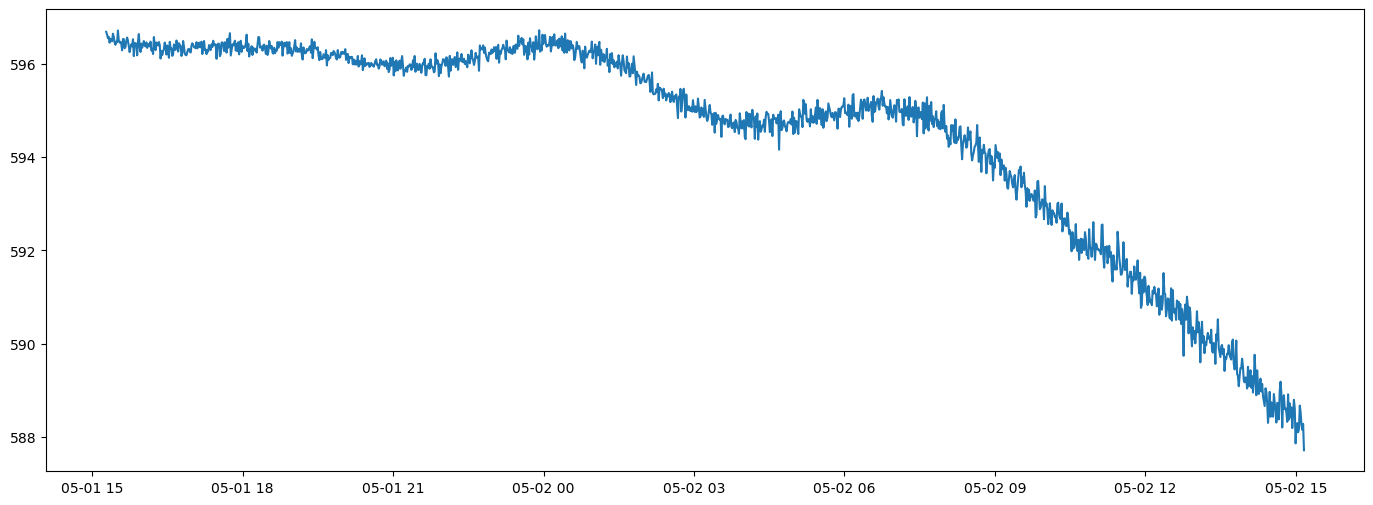

In [7]:
predict_prophet=predict_prophet[predict_prophet['ds']>='2025-05-01 15:16:00']
plt.figure(figsize=(17,6))
plt.plot(predict_prophet['ds'], predict_prophet['yhat_lower'])

In [ ]:
test_1[test_1['ds'] == '']

,ds,predict price,real price,difference,mismatch
0,2025-05-02 15:12:00,596.614141,600.506662,3.892521,0.006482
1,2025-05-02 15:16:00,596.519488,600.055383,3.535895,0.005893
2,2025-05-02 15:22:00,596.560968,599.798201,3.237233,0.005397
3,2025-05-02 15:27:00,596.458779,599.621895,3.163116,0.005275
4,2025-05-02 15:31:00,596.643291,599.143425,2.500135,0.004173
...,...,...,...,...,...
56,2025-05-02 19:50:00,596.603499,599.252072,2.648573,0.004420
57,2025-05-02 19:56:00,596.612446,599.100421,2.487974,0.004153
58,2025-05-02 20:05:00,596.657944,598.694594,2.036650,0.003402
59,2025-05-02 20:11:00,596.517029,599.515223,2.998193,0.005001


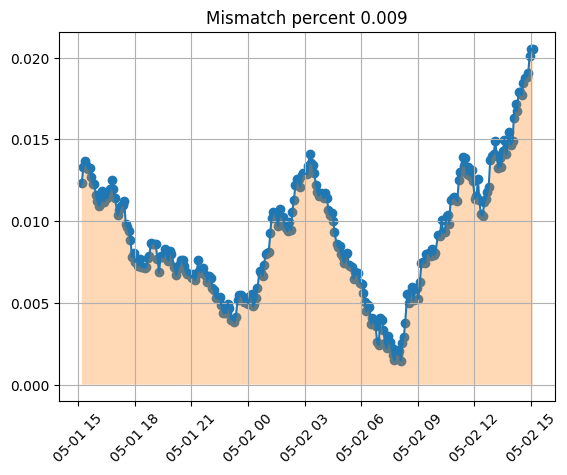

In [97]:
import matplotlib.dates as mdates

x = mdates.date2num(test_1['ds'])
y = test_1['mismatch']

plt.scatter(x=test_1['ds'], y=test_1['mismatch'])
plt.plot(test_1['ds'], test_1['mismatch'])
plt.fill_between(test_1['ds'], test_1['mismatch'], alpha=0.3)
plt.xticks(rotation=45)
plt.title(f'Mismatch percent {round(np.trapezoid(y,x), 4)}')
plt.grid(True)
plt.show()

In [42]:
error_medio = test_1['mismatch'].mean()
print(f'Error relativo medio: {round(error_medio, 2)}')


Error relativo medio: 0.41


In [97]:
data = get_data_crypto().download_data_cloud(start_time='2025-04-20', end_time='2025-04-30', crypto="binancecoin", time='min')
data

,timestamp,price
0,2025-04-20 00:04:52.398,591.865515
1,2025-04-20 01:04:39.381,593.282507
2,2025-04-20 02:02:23.509,592.545480
3,2025-04-20 03:04:43.083,592.280452
4,2025-04-20 04:04:16.349,592.559646
...,...,...
235,2025-04-29 19:04:54.490,604.103489
236,2025-04-29 20:06:29.819,603.214461
237,2025-04-29 21:05:02.546,601.155097
238,2025-04-29 22:04:58.489,600.509060


20:44:06 - cmdstanpy - INFO - Chain [1] start processing
20:54:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\santi\Anaconda3\envs\gpu_2_copy\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dates = pd.date_range(


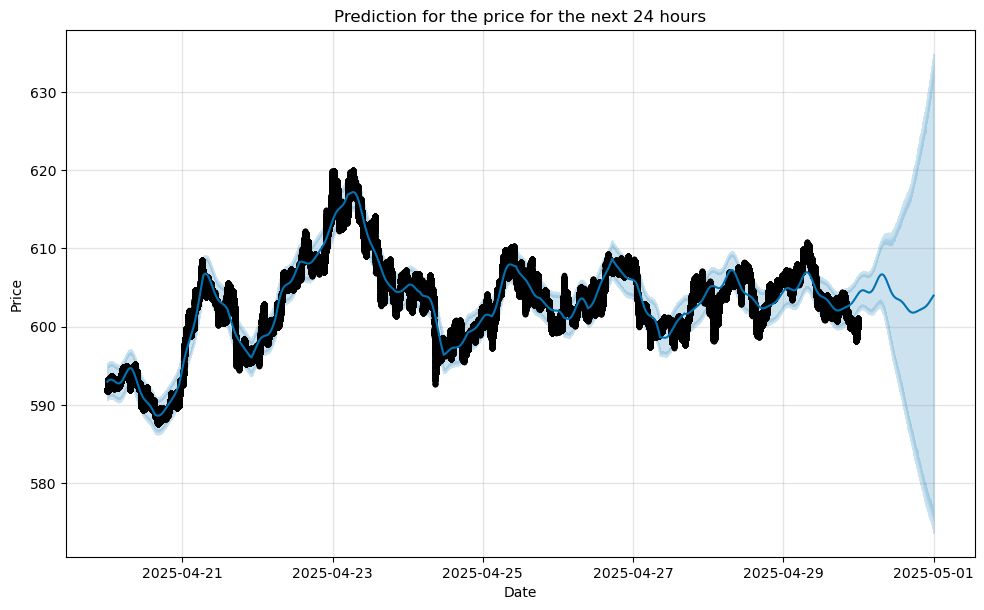

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')
Index(['ds', 'yhat'], dtype='object')


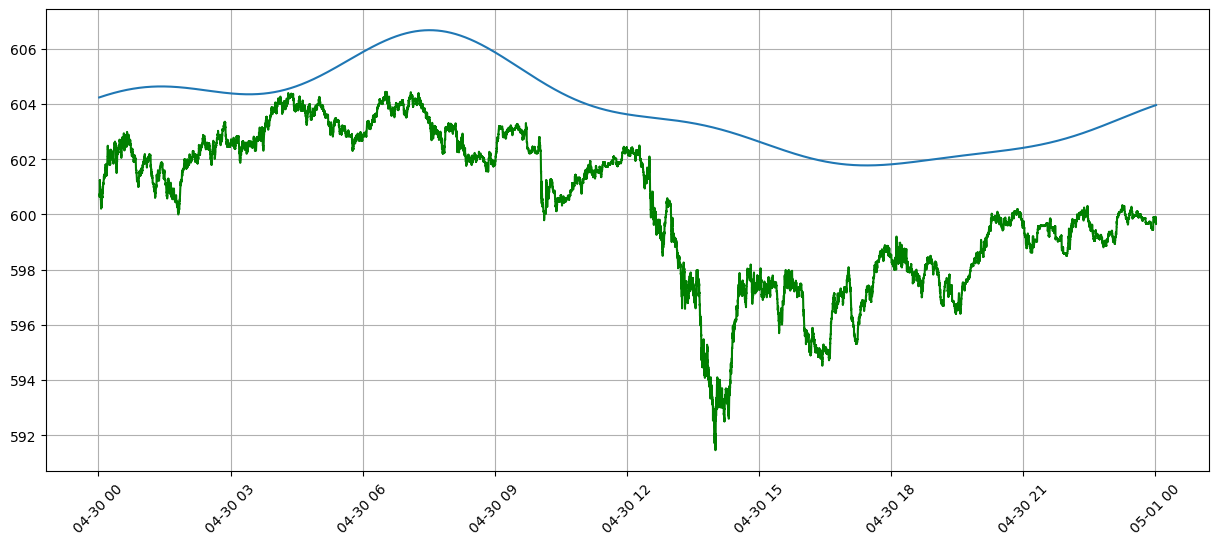

In [ ]:
data = get_data_crypto().download_data(start_time='2025-04-20', end_time='2025-04-30 00:01:00', crypto="BNBUSDT", time='S')
df_prophet, predict_prophet = prophet_model(data=data, time='S')

test_1 = data_predict(model=predict_prophet, crypto="BNBUSDT", time='S')
plt.figure(figsize=(15,6))
plt.plot(test_1['ds'], test_1['real price'], c='g')
plt.plot(test_1['ds'], test_1['predict price'])
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd

test_1.to_excel("test_1.xlsx", index=False)
data.to_excel("data.xlsx", index=False)
df_prophet.to_excel("df_prophet.xlsx", index=False)
predict_prophet.to_excel("predict_prophet.xlsx", index=False)


,ds,predict price,real price,Accuracy
0,2025-04-30 00:01:01.999,604.239871,600.72,1.01
1,2025-04-30 00:01:02.999,604.240021,600.72,1.01
2,2025-04-30 00:01:03.999,604.240170,600.71,1.01
3,2025-04-30 00:01:04.999,604.240319,600.71,1.01
4,2025-04-30 00:01:05.999,604.240468,600.71,1.01
...,...,...,...,...
86395,2025-05-01 00:00:56.999,603.961401,599.65,1.01
86396,2025-05-01 00:00:57.999,603.961550,599.65,1.01
86397,2025-05-01 00:00:58.999,603.961699,599.65,1.01
86398,2025-05-01 00:00:59.999,603.961849,599.65,1.01


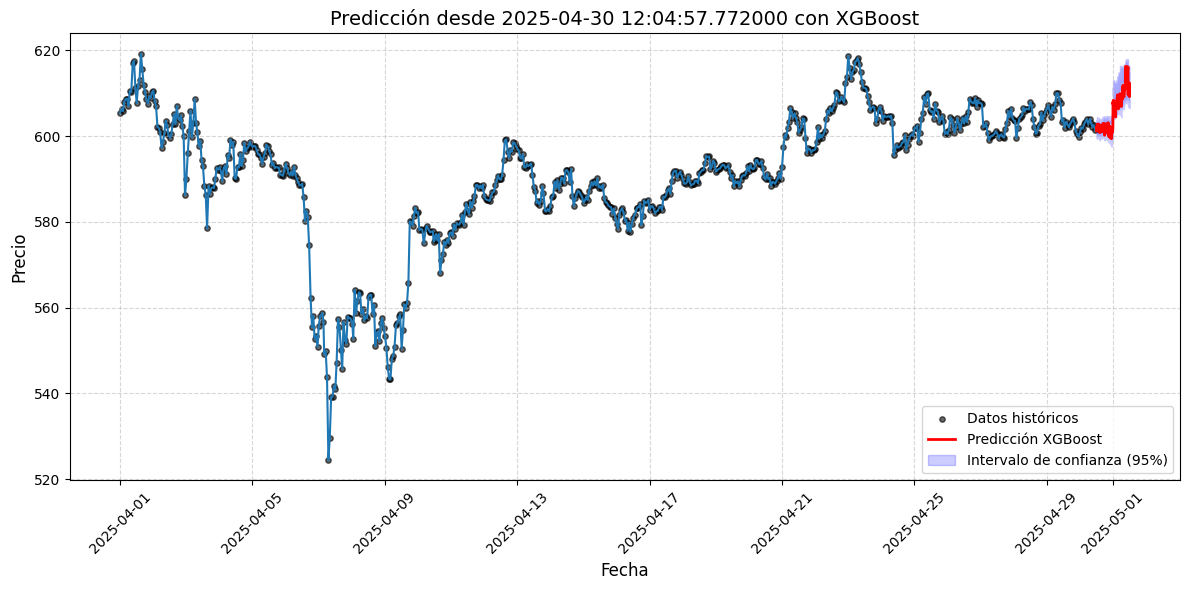

In [2]:
from utils import models, get_data_crypto

data = get_data_crypto().download_data_cloud(start_time='2025-04-01', end_time='2025-04-30 13:00:00', crypto="binancecoin", time='minutes')
x = models.XGBoost_model_bootstrap(data=data, time='m')

2025-04-30 20:08:27.174236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746043707.439376  313068 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746043707.611732  313068 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746043708.181775  313068 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746043708.181804  313068 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746043708.181807  313068 computation_placer.cc:177] computation placer alr

Epoch 1/10


2025-04-30 20:08:32.627761: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/workspaces/FinalHeimdall/mi_entorno/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1519
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0094
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0051
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0050
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0042
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0039
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0037
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0039
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0031
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━

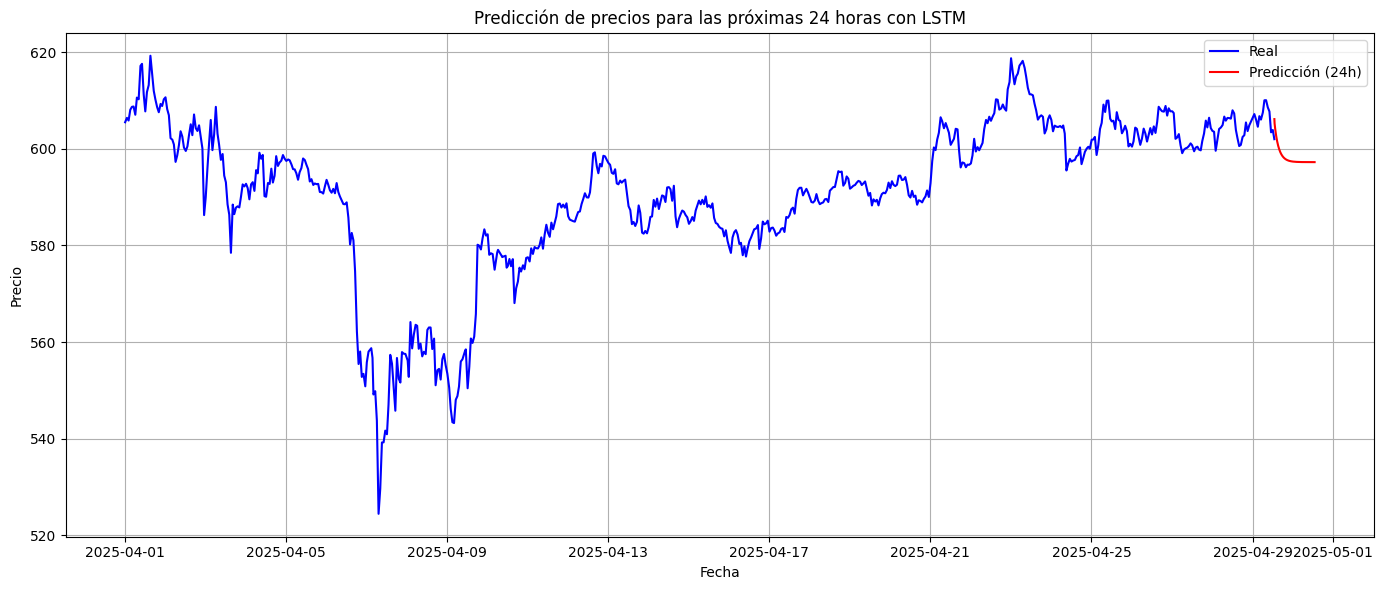

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

def lstm_predict_future(data, look_back=60, future_minutes=1440):
    data.columns = ['ds', 'y']
    df = data[['ds', 'y']].copy()
    df.set_index('ds', inplace=True)
    
    # Escalar
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['y']])

    # Crear secuencias para entrenamiento
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i - look_back:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # LSTM
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=10, batch_size=32, verbose=1)

    # Predicción futura
    future_predictions = []
    last_sequence = scaled_data[-look_back:].reshape(1, look_back, 1)

    for _ in range(future_minutes):
        next_pred = model.predict(last_sequence)[0][0]
        future_predictions.append(next_pred)
        # Actualizar secuencia para el próximo paso
        last_sequence = np.append(last_sequence[:, 1:, :], [[[next_pred]]], axis=1)

    # Invertir escala
    predicted_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Generar fechas futuras
    last_date = df.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(minutes=1), periods=future_minutes, freq='min')

    # Plot completo
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['y'], label='Real', color='blue')
    plt.plot(future_dates, predicted_prices, label='Predicción (24h)', color='red')
    plt.title('Predicción de precios para las próximas 24 horas con LSTM')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Retornar predicción como DataFrame
    df_future = pd.DataFrame({'ds': future_dates, 'y_pred': predicted_prices.flatten()})
    return df_future


data = get_data_crypto().download_data_cloud(start_time='2025-04-01', end_time='2025-04-29 14:00:00', crypto="binancecoin", time='minutes')
df_future = lstm_predict_future(data)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.2297 - val_loss: 0.0170 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0322 - val_loss: 0.0537 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0234 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0182 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0149 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0115 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0090 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0087 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0088 - val_loss: 0.0013 - learning_rate: 5.0000e-04
Epoch 10/100
8/8 ━━━━

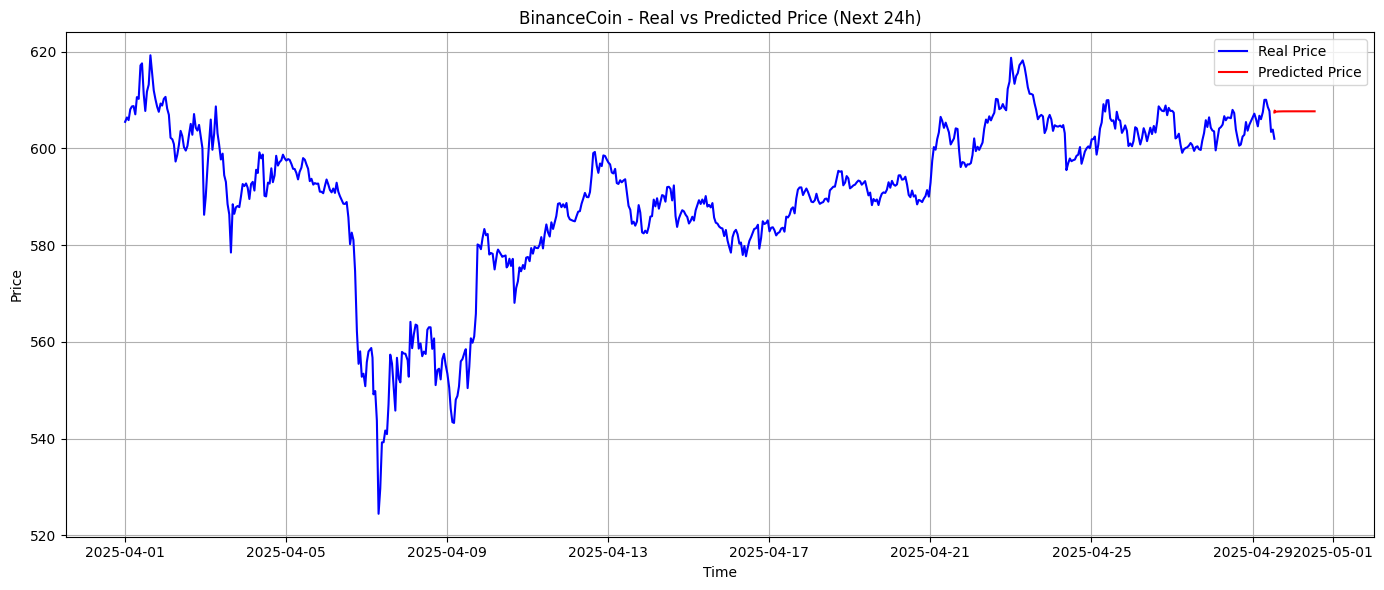

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

def preprocess_data(df, sequence_length=120):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    df['Close'] = df['price']
    df['minute'] = df.index.minute + df.index.hour * 60
    df['dayofweek'] = df.index.dayofweek
    features = ['Close', 'minute', 'dayofweek']
    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[features])
    
    X, y = [], []
    for i in range(sequence_length, len(scaled)):
        X.append(scaled[i-sequence_length:i])
        y.append(scaled[i, 0])
    return np.array(X), np.array(y), scaler, df[features]

def build_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def train_model(X, y):
    split = int(len(X) * 0.9)
    X_train, y_train = X[:split], y[:split]
    X_val, y_val = X[split:], y[split:]
    
    model = build_model(X.shape[1:])
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(patience=5, factor=0.5)
    ]
    
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=100, batch_size=64, callbacks=callbacks, verbose=1)
    return model

def predict_24h(model, last_seq, scaler, future_steps=1440):
    future_preds = []
    current_input = np.expand_dims(last_seq, axis=0)  # Asegura que tenga 3 dimensiones (1, seq_len, features)

    for _ in range(future_steps):
        pred = model.predict(current_input, verbose=0)
        future_preds.append(pred[0, 0])

        # Crear nuevo input para el próximo paso (forma: (1, 1, 3))
        avg_inputs = np.array([[pred[0, 0], 0.5, 0.5]])  # Promedio de los valores normalizados (close, minute, dayofweek)
        avg_inputs = avg_inputs.reshape(1, 1, 3)

        # Concatenar quitando el primer paso de la secuencia
        current_input = np.concatenate([current_input[:, 1:, :], avg_inputs], axis=1)

    # Desnormalización
    full_scaled = np.hstack([
        np.array(future_preds).reshape(-1, 1),
        np.full((future_steps, 2), 0.5)  # Columnas ficticias para minute y dayofweek
    ])
    inverse = scaler.inverse_transform(full_scaled)[:, 0]  # Solo la columna de precios
    return inverse

def plot_forecast(df_features, predictions):
    plt.figure(figsize=(14,6))
    real_prices = df_features['Close'][-1440:]  # Últimas 24 horas (1440 minutos)
    future_index = pd.date_range(start=real_prices.index[-1] + pd.Timedelta(minutes=1), periods=1440, freq='min')
    
    plt.plot(real_prices.index, real_prices.values, label="Real Price", color='blue')
    plt.plot(future_index, predictions, label="Predicted Price", color='red')
    plt.title("BinanceCoin - Real vs Predicted Price (Next 24h)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# 1. Cargar los datos
data = get_data_crypto().download_data_cloud(
    start_time='2025-04-01',
    end_time='2025-04-29 14:00:00',
    crypto="binancecoin",
    time='minutes'
)

# 2. Procesar los datos
X, y, scaler, df_feat = preprocess_data(data)

# 3. Entrenar el modelo
model = train_model(X, y)

# 4. Realizar la predicción para las siguientes 24 horas
last_seq = X[-1]  # Última secuencia de datos
preds = predict_24h(model, last_seq, scaler)

# 5. Mostrar las predicciones vs precios reales
plot_forecast(df_feat, preds)
